In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud

import en_core_web_sm
import textacy.extract

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [4]:
# Loading dataframe with reviews

df = pd.read_csv('archive/IMDB Dataset.csv')
df.shape

(50000, 2)

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data cleaning

In [6]:
# Creating a function for removing punctuations, stopwords, tokenization and lemmatization

lemmatizer = WordNetLemmatizer()

def clean_text(data):
    cleaned_text = []
    stopword = stopwords.words('english')
    
    for text in data:
        text = str(text).lower()
        text = re.sub(r'[^\w ]+', '', text)
        text = ' '.join([lemmatizer.lemmatize(word,pos='v') for word in word_tokenize(text) 
                         if not word in set(stopword) and len(word)>2])
        cleaned_text.append(text)        
    return cleaned_text

df['cleaned_reviews'] = clean_text(df.review.tolist())
df.head(3)

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewers mention watch episode youll hook...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...


### Creating wordcloud

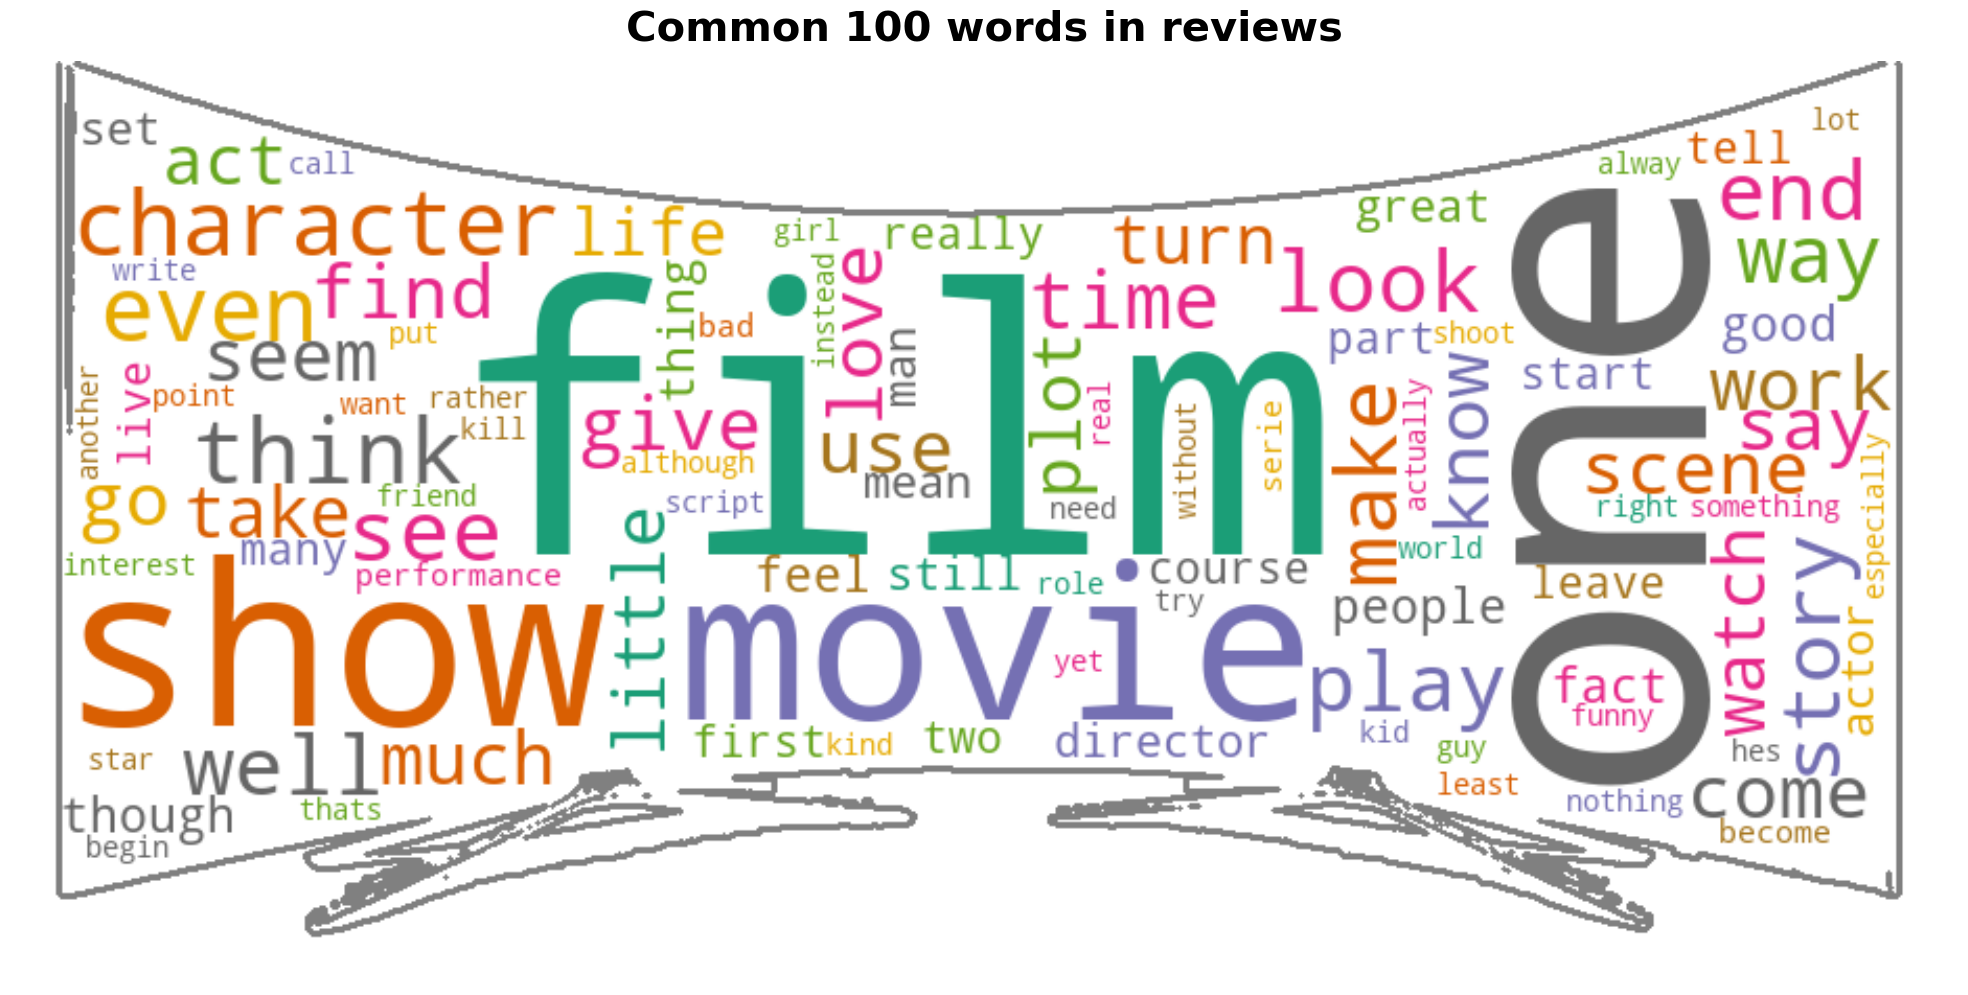

In [ ]:
# Create a wordcloud

def showWordCloud(data):
    plane_mask = np.array(Image.open("pict/tv.jpeg"))
    plane_mask = plane_mask / 255
    plane_mask = plane_mask.round()
    plane_mask = plane_mask * 255
    
    unite_reviews = ' '.join(data)
    cleaned_reviews = ' '.join([word for word in unite_reviews.split()])
    wordcloud = WordCloud(background_color='white', 
                          mask=plane_mask, max_words=100, 
                          contour_width=3, contour_color='gray',
                          colormap='Dark2',
                          min_font_size=10
                         ).generate(cleaned_reviews)
    plt.figure(figsize = (45,12))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('Common 100 words in reviews', pad = 15, weight = 'bold', fontsize = 30)
    plt.show();
    
showWordCloud(df.cleaned_reviews)

### Analysis of viewer's opinions - extracting information

In [ ]:
# Analysis of the context in which viewer's mentioned, for example, Bred Pitt, Hollywood and comedy

# Loading the NLP model
nlp = en_core_web_sm.load()

# Using the loop, the model will parse the text in parts, since there is a limit on the number of incoming characters
# The analysis is performed on phrase 'Bred Pitt'
print('What people say about Bred Pitt:\n')
n_facts = 0
for i in range(0, 100):
    if n_facts <= 25:
        text = ' '.join(map(str,df.review.tolist()[i * 500:(i + 1) * 500]))
        text = text.replace('<br />', '')
        doc = nlp(text)
        statements_1 = textacy.extract.semistructured_statements(doc, entity=re.compile('brad pitt', re.IGNORECASE), cue=('be'))
        for statement in statements_1:
            n_facts += 1
            subject, verb, fact = statement
            print(f' - {(' '.join(map(str,fact))).strip(',./-_')}')
    else:
        break

What people say about Bred Pitt:

 - a strict man whose two passions are his faith and fly fishing 
 - HORRIBLE and thoroughly annoying throughout the entire move
 - the real surprise
 - to say the least , remarkable


In [ ]:
# Similarly, find out the context in which the word 'Hollywood' occurs
print('What people say about Hollywood:\n')
n_facts = 0
for i in range(0, 100):
    if n_facts <= 25:
        text = ' '.join(map(str,df.review.tolist()[i * 500:(i + 1) * 500]))
        text = text.replace('<br />', '')
        doc = nlp(text)
        statements_1 = textacy.extract.semistructured_statements(doc, entity=re.compile('hollywood', re.IGNORECASE), cue=('be'))
        for statement in statements_1: 
            n_facts += 1
            subject, verb, fact = statement
            print(f' - {(' '.join(map(str,fact))).strip(',./-_')}')
    else:
        break

What people say about Hollywood:

 - idiots
 - more liberal / democrat than the bush&co
 - nothing but an ugly reality TV party
 - very pro Nazi
 - to be believed
 - the place for serious history lessons
 - one of the best and the beautiful things that had occurred in my life
 - definitive not th right address to make films about the Balcan peninsula
 - a corrupt town
 - such a small insular community
 - a nest of viper 's and decadents
 - the only place where people can make over - emotional , melodramatic movies


In [ ]:
# ... and the word 'comedy'(limiting to the first 25 phrases to reduce processing time)
print('What people say about comedyes:\n')
n_facts = 0
for i in range(0, 100):
    if n_facts <= 25:
        text = ' '.join(map(str,df.review.tolist()[i * 500:(i + 1) * 500]))
        text = text.replace('<br />', '')
        doc = nlp(text)
        statements_1 = textacy.extract.semistructured_statements(doc, entity=re.compile('comedy', re.IGNORECASE), cue=('be'))
        for statement in statements_1:
            subject, verb, fact = statement
            phrase = (' '.join(map(str,fact))).strip(',./-_')
            if len(phrase.split()) >= 2:
                print(f' - {phrase}')
                n_facts += 1
    else:
        break    

What people say about comedyes:

 - the pitiful attempt to give comic relief lines to Wanda Sykes
 - an easy sell
 - madcap , with breakneck gags
 - the little British effort " The Divorce Of Lady X ( 1938 )
 - a brilliant piece of social commentary
 - a very cruel joke at the expense of the actors
 - a great satire that made me question if what I accept as the infallible true history is really true
 - the worst kind of High Concept drivel
 - his strong suit
 - to entertain
 - nothing less of spectacular
 - funny characters , smart and funny dialogue , and grand entertainment
 - a coming out party for Pierce Brosnan the actor
 - his real element
 - the most prominent thing here
 - his forte
 - not the elephant
 - typical Blake Edwards
 - the Trouble with Harry
 - a rarity
 - a product of John Ford , especially with Victor McLaglen as one of the leads
 - so great mind
 - bad comedy
 - your strong suit
 - something that all needed to constantly improve upon
 - slap - stick


### Most frequent words

In [ ]:
# Creating a function to display the most frequent words

def words_frequency(text, top_n = 20):
    words = ' '.join([sent for sent in text])
    words = words.split()
    freq_dist = FreqDist(words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
  
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns='count', n=top_n) 
    plt.figure(figsize=(15,8))
    ax = sns.barplot(data=d, x='word', y='count')
    ax.set(ylabel='Count')
    plt.show();

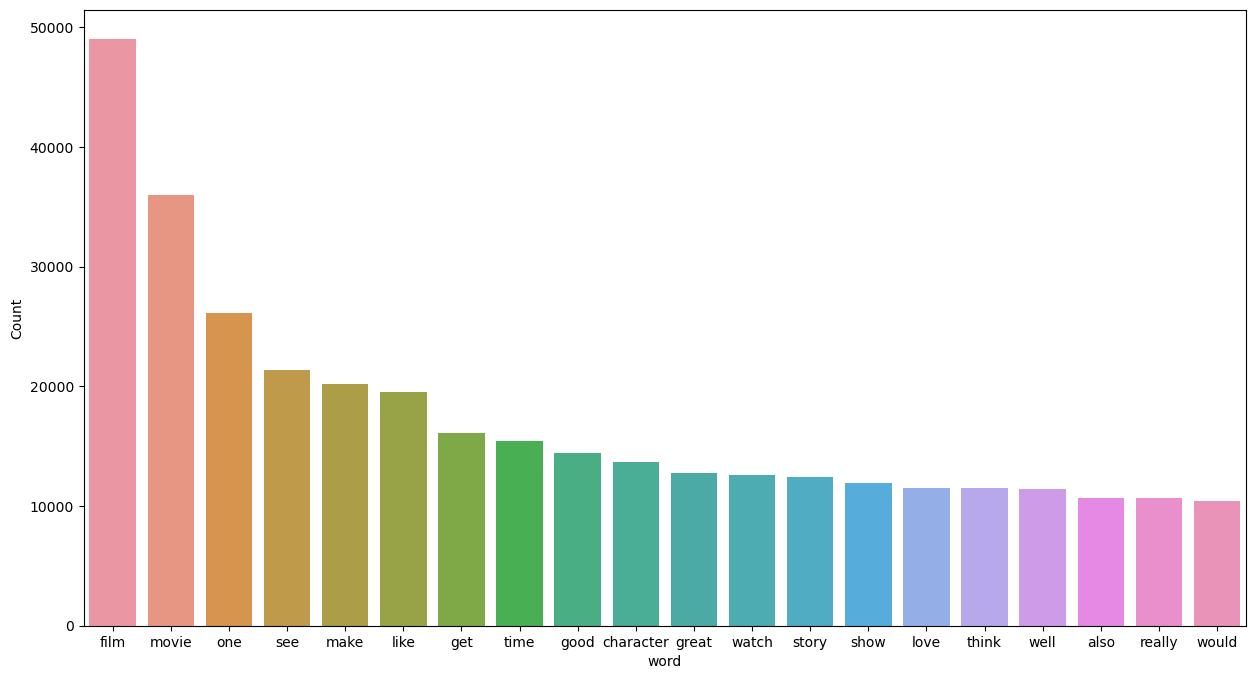

In [ ]:
# Display the top-20 most frequently used words in positive reviews
words_frequency(df.cleaned_reviews[df.sentiment == 'positive'].tolist())

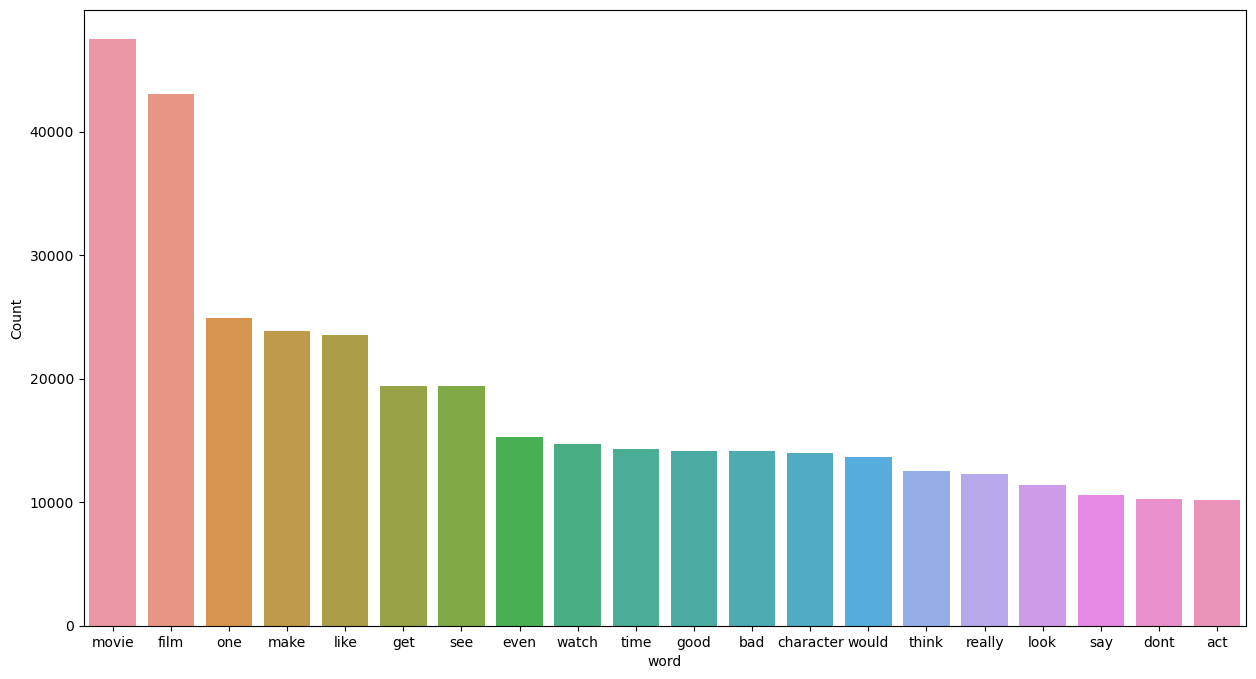

In [ ]:
# ... and the top-20 most frequently used words in negative reviews
words_frequency(df.cleaned_reviews[df.sentiment == 'negative'].tolist())

##### As we can see, the top 20 words in positive and negative reviews do not differ much, except that the top 20 words in negative reviews include the words 'bad' and 'don't'. Probably, users use all the same words, adding 'don't' in front of them :-)

### Topic modeling

In [26]:
# Topic modeling with the contextualized_topic_models library, based on pytorch and BERT, which allows to significantly 
# speed up the process using CUDA

qt = TopicModelDataPreparation('paraphrase-distilroberta-base-v2')
training_dataset = qt.fit(text_for_contextual=df.review.tolist(), text_for_bow=df.cleaned_reviews.tolist())
ctm = CombinedTM(bow_size=len(qt.vocab), contextual_size=768, n_components=20) # 20 topics
ctm.fit(training_dataset)

for i in range(len(ctm.get_topics())):
    print(f'topic {i + 1}:', ctm.get_topics()[i])

topic 1: ['noir', 'soldier', 'man', 'men', 'war', 'city', 'hero', 'american', 'power', 'lead']
topic 2: ['semblance', 'namebr', 'unintelligible', 'cliched', 'unimpressed', 'catatonic', 'requiem', 'visibly', 'aggressively', 'staggeringly']
topic 3: ['sinatra', 'broadway', 'matthau', 'kelly', 'joan', 'mgm', 'mary', 'stage', 'musicals', 'ray']
topic 4: ['team', 'match', 'game', 'batman', 'episode', 'series', 'show', 'kid', 'good', 'get']
topic 5: ['scold', 'aggressively', 'frustratingly', 'tar', 'tshirt', 'gimmicky', 'recipient', 'motionless', 'alexs', 'catatonic']
topic 6: ['ninja', 'mummy', 'snowman', 'freddy', 'puppet', 'dinosaurs', 'scarecrow', '13th', 'carnosaur', 'jurassic']
topic 7: ['rotate', 'kelley', 'aggressively', 'scold', 'matte', 'alexs', 'prototype', 'purists', 'adrian', 'liken']
topic 8: ['cancel', 'abc', 'bug', 'cartoon', 'trek', 'network', 'program', 'sitcom', 'anime', 'barney']
topic 9: ['one', 'film', 'make', 'find', 'time', 'take', 'come', 'much', 'scene', 'give']
top

In [ ]:
# Some of the topics are even understandable :)

### Classification model with TensorFlow

In [7]:
# Assign each word its own numerical value using the tokenizer from tensorflow.keras.preprocessing.text. 

num_words=50000
words = ' '.join([sent for sent in df.cleaned_reviews])

tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts([words])
total_words = len(tokenizer.word_index)+1

In [8]:
# Convert the sentences into the corresponding numerical sequence using tokenizer and count the number of words in each review 

df['tokenazed_reviews'] = tokenizer.texts_to_sequences(df.cleaned_reviews)
df['tokens_amount'] = df.tokenazed_reviews.apply(lambda x: len(x))
df.head(3)

,review,sentiment,cleaned_reviews,tokenazed_reviews,tokens_amount
0,One of the other reviewers has mentioned that ...,positive,one reviewers mention watch episode youll hook...,"[3, 1670, 327, 11, 319, 373, 1482, 109, 496, 1...",155
1,A wonderful little production. <br /><br />The...,positive,wonderful little production film technique una...,"[304, 50, 282, 1, 2583, 15113, 1081, 29, 3109,...",80
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...,"[14, 304, 40, 343, 8, 780, 1231, 2055, 306, 62...",82


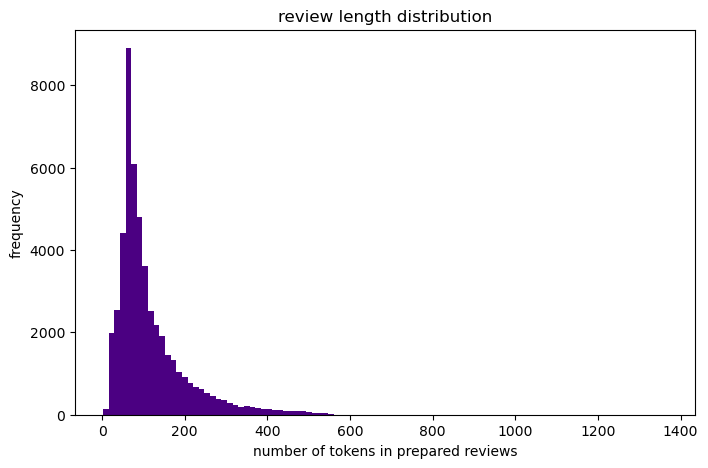

In [9]:
# Check the distribution of the length of reviews (number of words)

plt.figure(figsize=(8, 5))
plt.hist(df.tokens_amount, bins=100, color='indigo')
plt.xlabel('number of tokens in prepared reviews')
plt.ylabel('frequency')
plt.title('review length distribution')
plt.show();

In [10]:
# Create a function to calculate the interquartile range 

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries
boundaries = calculate_outliers(df.tokens_amount)
print('Upper boundary of the interquartile range - ', boundaries[1])

Upper boundary of the interquartile range -  259.5


In [11]:
# Align the length of the sequences to the upper bound of the interquartile range

len_sequence = round(boundaries[1])
X = pad_sequences(df.tokenazed_reviews, maxlen=len_sequence)

In [12]:
# Encode the target variable with LebelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(df.sentiment)

In [13]:
# Split the data into train and test samples with the ratio 50/50

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.5, random_state=42)
print(f'train size - {Xtrain.shape}\ntest size - {Xtest.shape}')

train size - (25000, 260)
test size - (25000, 260)


In [20]:
# Build the architecture of the TensorFlow NN with Embedding layer, three 1D convolution layers with kernels 8, 4 and 4 respectively
# Add BatchNormalization layer after each convolutional layer to solve the problem of vanishing gradients, and also MaxPooling1D layer 
# for dimensionality reduction and Dropout layer to avoid overfitting. Then use the Flatten layer and Dense (densely-connected) layer. 

model = Sequential()

model.add(Embedding(num_words, 16, input_length=len_sequence))

model.add(Conv1D(512, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Dropout(0.4))

model.add(Conv1D(256, 4, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Dropout(0.4))

model.add(Conv1D(128, 4, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.0015)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 260, 16)           800000    
                                                                 
 conv1d_9 (Conv1D)           (None, 260, 512)          66048     
                                                                 
 batch_normalization_12 (Bat  (None, 260, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 130, 512)         0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 130, 512)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 130, 256)         

In [21]:
# Train the model for 3 epochs with batch_size=32, the size of the validation sample is 0.1 (10%).

history = model.fit(Xtrain, ytrain, epochs=3, verbose=1, batch_size=32, validation_split=0.1)

Epoch 1/3
704/704 [==============================] - 27s 37ms/step - loss: 0.5312 - accuracy: 0.7313 - val_loss: 0.4835 - val_accuracy: 0.7716
Epoch 2/3
704/704 [==============================] - 26s 37ms/step - loss: 0.2150 - accuracy: 0.9162 - val_loss: 0.3562 - val_accuracy: 0.8636
Epoch 3/3
704/704 [==============================] - 26s 37ms/step - loss: 0.1091 - accuracy: 0.9618 - val_loss: 0.4361 - val_accuracy: 0.8680


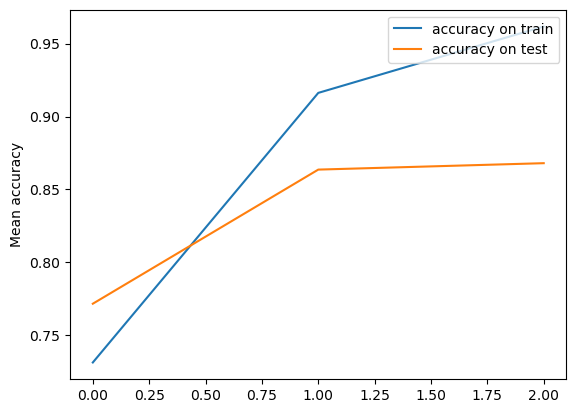

In [22]:
# Learning history visualization

plt.plot(history.history['accuracy'], label='accuracy on train')
plt.plot(history.history['val_accuracy'], label='accuracy on test')
plt.ylabel('Mean accuracy')
plt.legend(loc='upper right')
plt.show()

In [23]:
# Print model loss/metric for test sample

score = model.evaluate(Xtest, ytest, verbose=1)
print('test loss:', round(score[0], 4))
print('test accuracy:', round(score[1], 4))

782/782 [==============================] - 8s 10ms/step - loss: 0.4011 - accuracy: 0.8709
test loss: 0.4011
test accuracy: 0.8709


In [ ]:
# The model metrics are not bad - 0.96 accuracy on the training set and 0.87 on the test one, but this difference indicates 
# that the model is overfitting. You can try to increase the percentage of disconnected neurons in the dropout layer or apply 
# a neural network architecture with other layers, such as LSTM (Bidirectional) (in fact, I tried such architectures and got 
# about the same results or even worse). Probably the most effective result can be obtained using pre-trained models, such 
# as BERT variations (for example, DistilBERT).